In [1]:
# Internal StatViz notebook to demonstrate different types of visualizations based on variable combinations
# The following variables from COPDGene will be used:
# Gender (Male or Female)
# Age at enrollment (continuous, min 39.9 max 85)
# BMI (continuous, min 12.29 max 64.1)
# Asthma: have you ever had asthma (No, Yes, Do not know)

In [1]:
# Do imports
import sys
!{sys.executable} -m pip install -r requirements.txt
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds.git

import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureClient
import PicSureBdcAdapter

from utils import get_multiIndex_variablesDict, joining_variablesDict_onCol

  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /tmp/pip-req-build-aywqs7kd
  Running command git clone --filter=blob:none -q https://github.com/hms-dbmi/pic-sure-python-client.git /tmp/pip-req-build-aywqs7kd
  Resolved https://github.com/hms-dbmi/pic-sure-python-client.git to commit aabcc6574eede2dc3de410c6c75f7f77ea18d23c
  Preparing metadata (setup.py) ... done
  Created wheel for PicSureClient: filename=PicSureClient-0.1.0-py2.py3-none-any.whl size=10300 sha256=17f9d27ff8d3aa341eec89db1372a2d32f696f0768c20c1a18f72fbc2973109f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5kk9b324/wheels/31/ef/21/e362bba8de04e0072fafec9f77bd1abdf7e166213d27e98729
Successfully built PicSureClient
  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /tmp/pip-req-build-t3qieeed
  Running command git clone --filter=blob:none -q https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /tmp/pip-req-build-t3qieeed
  Resolved https://github.com/hms-dbmi/pic-su

In [2]:
# Connect to PIC-SURE
PICSURE_network_URL = "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
resource_id = "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file = "token.txt"
with open(token_file, "r") as f:
    my_token = f.read()
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, my_token, True)
adapter = PicSureBdcAdapter.Adapter(connection)
resource = adapter.useResource(resource_id)



+=========================================================================================+
|        [ WARNING ] you are specifying that you WANT to allow self-signed SSL            |
|        certificates to be acceptable for connections.  This may be useful for           |
|        working in a development environment or on systems that host public              |
|        data.  BEST SECURITY PRACTICES ARE THAT IF YOU ARE WORKING WITH SENSITIVE        |
|        DATA THEN ALL SSL CERTS BY THOSE EVIRONMENTS SHOULD NOT BE SELF-SIGNED.          |
+=========================================================================================+

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 |                         

In [4]:
# Get all COPDGene variables - find those of interest
plain_variablesDict = resource.dictionary().find("COPDGene").DataFrame()
gender_mask = ["\\Gender\\" in i for i in plain_variablesDict.index]
gender = plain_variablesDict[gender_mask].index[0]
age_mask = ['\\Age at enrollment\\' in i for i in plain_variablesDict.index]
age = plain_variablesDict[age_mask].index[0]
bmi_mask = ["\\BMI\\" in i for i in plain_variablesDict.index]
bmi = plain_variablesDict[bmi_mask].index[0]
asthma_mask = ['\\Asthma: have you ever had asthma' in i for i in plain_variablesDict.index]
asthma = plain_variablesDict[asthma_mask].index[0]
all_vars = [gender, age, bmi, asthma]

In [5]:
# Build query and export data
query = resource.query()
query.anyof().add(all_vars)
query_result = query.getResultsDataFrame(low_memory=False)

In [6]:
# Clean up dataframe
new_cols = []
for i in query_result.columns:
    splits = i.split("\\")
    if splits[-1] == '':
        new_cols.append(splits[-2])
    else:
        new_cols.append(splits[-1])
#print(new_cols)
query_result.columns = new_cols

In [7]:
query_result

,Patient ID,Age at enrollment,Asthma: have you ever had asthma,BMI,Gender,_Parent Study Accession with Subject ID,_Topmed Study Accession with Subject ID,_consents
0,35416,65.5,No,20.28,Female,phs000179.v6_COPDGene_A00282,phs000951.v4_COPDGene_A00282,phs000179.c2
1,35417,50.3,No,19.61,Male,phs000179.v6_COPDGene_A00444,phs000951.v4_COPDGene_A00444,phs000179.c1
2,35419,52.2,No,53.75,Female,phs000179.v6_COPDGene_A01052,phs000951.v4_COPDGene_A01052,phs000179.c1
3,35420,62.8,No,22.66,Female,phs000179.v6_COPDGene_A01133,phs000951.v4_COPDGene_A01133,phs000179.c1
4,35421,57.5,Yes,40.58,Female,phs000179.v6_COPDGene_A01220,phs000951.v4_COPDGene_A01220,phs000179.c1
...,...,...,...,...,...,...,...,...
10366,46110,52.8,No,33.57,Female,phs000179.v6_COPDGene_Y07242,NaN,phs000179.c1
10367,46111,61.9,Yes,24.87,Female,phs000179.v6_COPDGene_Y23466,NaN,phs000179.c1
10368,46112,51.7,Yes,22.78,Female,phs000179.v6_COPDGene_Y40862,NaN,phs000179.c1
10369,46113,50.0,No,25.09,Male,phs000179.v6_COPDGene_Y76409,NaN,phs000179.c2


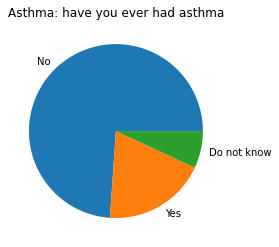

In [8]:
# Scenario 1: One categorical (asthma)
# Pie plot
no = sum(query_result["Asthma: have you ever had asthma"] == 'No')
#print(no)
yes = sum(query_result["Asthma: have you ever had asthma"] == 'Yes')
#print(yes)
idk = sum(query_result["Asthma: have you ever had asthma"] == 'Do not know')
#print(idk)
fig, ax = plt.subplots()
ax.pie([no, yes, idk], labels=["No", "Yes", "Do not know"])
ax.set_title("Asthma: have you ever had asthma")
plt.show()

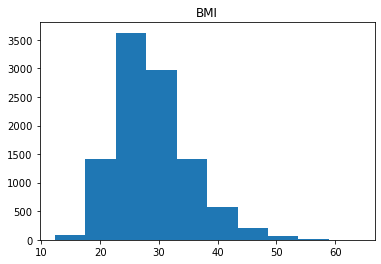

In [9]:
# Scenario 2: One continuous (BMI)
# histogram
fig, ax = plt.subplots()
ax.hist(query_result["BMI"])
ax.set_title("BMI")
plt.show()

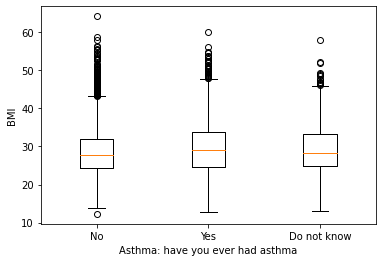

In [10]:
# Scenario 3: Continuous x, categorical y (BMI on x, asthma on y)
# boxplot
# make data:
#np.random.seed(10)
#D = np.random.normal((3, 5, 4), (1.25, 1.00, 1.25), (100, 3))
no_mask = query_result["Asthma: have you ever had asthma"] == 'No'
yes_mask = query_result["Asthma: have you ever had asthma"] == 'Yes'
idk_mask = query_result["Asthma: have you ever had asthma"] == 'Do not know'

data = [query_result.BMI[no_mask], query_result.BMI[yes_mask], query_result.BMI[idk_mask]]

# plot
fig, ax = plt.subplots()
ax.boxplot(data, labels=['No', 'Yes', 'Do not know'])
ax.set_ylabel("BMI")
ax.set_xlabel("Asthma: have you ever had asthma")
plt.show()

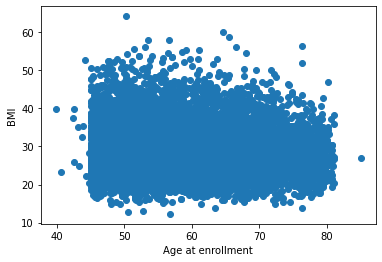

In [12]:
# Scenario 4: Continuous vs continuous (BMI vs Age)
# Scatter plot
fig, ax = plt.subplots()
ax.scatter(query_result["Age at enrollment"], query_result['BMI'])
ax.set_ylabel("BMI")
ax.set_xlabel("Age at enrollment")
plt.show()

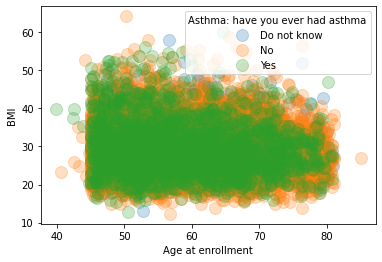

In [21]:
# Scenario 5: Continuous vs Continuous, grouped by categorical (BMI vs age, grouped by asthma status)
fig, ax = plt.subplots()
#ax.scatter(query_result["Age at enrollment"], query_result['BMI'], c=query_result['Asthma: have you ever had asthma']

groups = query_result.groupby('Asthma: have you ever had asthma')
for name, group in groups:
    ax.plot(group['Age at enrollment'], group['BMI'], marker='o', linestyle='', markersize=12, label=name, alpha = 0.25)
ax.set_ylabel("BMI")
ax.set_xlabel("Age at enrollment")
plt.legend(title="Asthma: have you ever had asthma")

In [3]:
plain_variablesDict = resource.dictionary().find("CHS").DataFrame()

In [4]:
# Statviz v2 visualization example
bmi_mask = ["\\BODY MASS INDEX\\" in i for i in plain_variablesDict.index]
bmi = plain_variablesDict[bmi_mask].index[0]
asthma_mask = ["\\Ever asthma confirmed by a doctor\\" in i for i in plain_variablesDict.index]
asthma = plain_variablesDict[asthma_mask].index[0]
gender_mask = ["\\Gender\\" in i for i in plain_variablesDict.index]
gender = plain_variablesDict[gender_mask].index[0]
all_vars = [bmi, asthma, gender]
# Build query and export data
query = resource.query()
query.anyof().add(all_vars)
query_result = query.getResultsDataFrame(low_memory=False)

In [5]:
# Clean up dataframe
new_cols = []
for i in query_result.columns:
    splits = i.split("\\")
    if splits[-1] == '':
        new_cols.append(splits[-2])
    else:
        new_cols.append(splits[-1])
#print(new_cols)
query_result.columns = new_cols

In [6]:
query_result

,Patient ID,BODY MASS INDEX,Gender,Ever asthma confirmed by a doctor,_Parent Study Accession with Subject ID,_Topmed Study Accession with Subject ID,_consents
0,28791,41.645475,Female,NO,phs000287.v7_100051,NaN,phs000287.c1
1,28792,32.059293,Male,NO,phs000287.v7_100425,phs001368.v2_100425,phs000287.c1
2,28793,19.928132,NaN,NaN,phs000287.v7_100434,phs001368.v2_100434,phs000287.c1
3,28794,19.928132,NaN,NO,phs000287.v7_100854,NaN,phs000287.c1
4,28795,23.678376,NaN,NO,phs000287.v7_101032,phs001368.v2_101032,phs000287.c1
...,...,...,...,...,...,...,...
5525,34408,24.491361,NaN,NO,phs000287.v7_621121,phs001368.v2_621121,phs000287.c1
5526,34409,26.522016,NaN,NO,phs000287.v7_708028,phs001368.v2_708028,phs000287.c1
5527,34410,30.636578,NaN,NO,phs000287.v7_708270,phs001368.v2_708270,phs000287.c2
5528,34411,20.926169,NaN,NO,phs000287.v7_746158,phs001368.v2_746158,phs000287.c1


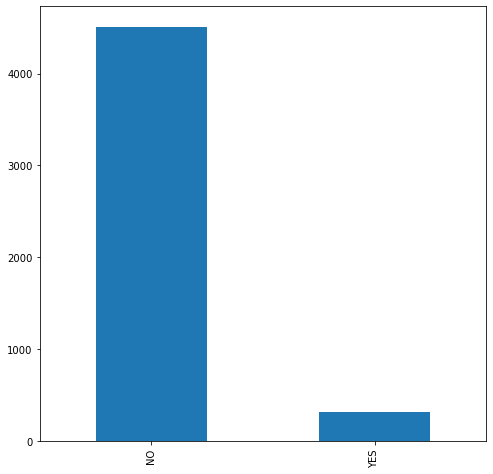

In [17]:
fig, ax = plt.subplots()

ax = query_result['Ever asthma confirmed by a doctor'].value_counts().plot(kind='bar',
                                    figsize=(8,8),
                                    title="")
#ax.set_xlabel("Owner Names")
#ax.set_ylabel("Frequency")

In [44]:
#fig, ax = plt.subplots()
no = query_result['Ever asthma confirmed by a doctor'] == 'NO'#['BODY MASS INDEX']
yes = query_result['Ever asthma confirmed by a doctor'] == 'YES'#['BODY MASS INDEX']
#full = [query_result['BODY MASS INDEX', no] yes]
#fig, ax = plt.subplots()
#ax.boxplot(full, labels=['NO', 'YES'])
#ax.set_ylabel("BMI")
#ax.set_xlabel("Asthma: have you ever had asthma")
#plt.show()

In [51]:
full = [query_result['BODY MASS INDEX'].loc[no], query_result['BODY MASS INDEX'].loc[yes]]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1ec5c37b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1ec5c3240>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1ec5c3eb8>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe1ec98d320>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1ec98deb8>,
 'means': []}

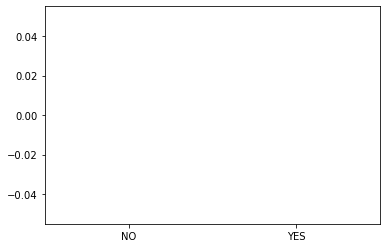

In [53]:
fig, ax = plt.subplots()
ax.boxplot(full, labels=['NO', 'YES'])
#ax.set_ylabel("BMI")
#ax.set_xlabel("Asthma: have you ever had asthma")
#plt.show()

In [54]:
import numpy as np
np.random.seed(10)
data = np.random.normal(100, 20, 200)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1ec464be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1ec4711d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1ec464978>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1ec471780>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1ec471a58>],
 'means': []}

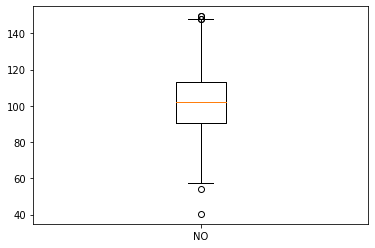

In [57]:
fig, ax = plt.subplots()
ax.boxplot(data, labels=['NO'])

In [59]:
np.array(full)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


array([0       41.645475
1       32.059293
3       19.928132
4       23.678376
5       21.346278
          ...    
5525    24.491361
5526    26.522016
5527    30.636578
5528    20.926169
5529    33.744585
Name: BODY MASS INDEX, Length: 4505, dtype: float64,
       35      27.729230
51      26.280486
53      21.999093
58      24.140711
65      25.074275
          ...    
5498    29.642587
5500    27.279324
5501    29.873144
5521    25.547309
5523    21.112277
Name: BODY MASS INDEX, Length: 322, dtype: float64], dtype=object)

In [60]:
data

array([126.63173008, 114.30557949,  69.09199416,  99.832323  ,
       112.42671948,  85.59828879, 105.31023171, 102.17097051,
       100.08582862,  96.50799579, 108.6605238 , 124.06074748,
        80.69868659, 120.56548156, 104.5726026 , 108.90275226,
        77.26795576, 102.70273757, 129.69074004,  78.40390228,
        60.44543439,  65.13255408, 105.32140328, 147.69934661,
       122.47382507, 133.45244427, 101.98298432, 127.95992754,
        94.57504024, 112.2640837 ,  94.65365623,  89.01381972,
       102.65416592,  90.4771597 , 126.16946162, 103.90026558,
       108.00419977,  93.24735326, 125.12944528,  85.36060996,
       113.20463102,  92.98256217,  81.2113328 ,  90.21325566,
        83.90817715,  95.74604723,  93.21719508, 106.24339873,
       111.30305339,  97.05159485,  99.48189326, 105.78188408,
        89.20241857, 114.1632004 , 116.84449477, 104.07161595,
       147.8940733 , 118.34917875,  97.75455058,  92.75639106,
        95.35635488,  89.96542201, 122.57570306,  86.04